# X-Ray Image Labelling & Reporting
## Image Captioning
**`Team AKAKI!` | `Minerva University`**

---


**`Goals:`**
- Caption images using computer vision and NLP.
- Test caption similarities to real captions using BLEU score.

This work is inspired by the following [article](https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/#:~:text=deep%20learning%20model.-,Defining%20the%20Model,-We%20will%20define)

### Import Libraries

In [ ]:
from pickle import load
import numpy as np
import pandas as pd
from PIL import Image
from numpy import argmax
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import add
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model


### Import Data

In [ ]:
frontal_train = pd.read_pickle("../data/train/frontal_train.pickle").reset_index(drop=True)

root_dir = "/datasets/gdrive/XRay-AKAKI/images_normalized/"

frontal_test = pd.read_pickle('../data/test/frontal_test.pickle').reset_index(drop=True)
#test_descs = frontal_test['caption']

#Randomly select 20 x-ray images for train and 20 for testing
train = frontal_train.sample(20)
test = frontal_test.sample(20)

train_path = train['filename']
test_path = test['filename']

train_descs = train['caption']
test_descs = test['caption']

### Creating Utility Functions

In [ ]:
# extract features from each photo in the directory
def extract_features(filenames):
    """
    Function to extract the features of the images using VGG16.
    """
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # summarize
    print(model.summary())
    # extract features from each photo
    features = dict()

    indexes = filenames.index.values

    for index, filename in zip(indexes, filenames):
        # load an image from file
        image = load_img(root_dir+filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = index
        # store feature
        features[image_id] = feature
        print('>%s' % filename)
    return features

In [ ]:
def create_tokenizer(descriptions):
    """
    Function to generate tokenizer by fitting on descriptions.
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(descriptions)
    return tokenizer


def to_max_length(lines):
    """
    Function to calculate the length of the descriptions with the most words.
    """
    
    return max(len(d.split()) for d in lines)


def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    """
    Create sequences of images, input sequences and output words for an image
    """
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():
        # walk through each description for the image
        for desc in desc_list:
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [ ]:
def define_model(vocab_size, max_length):
    """
    Define the captioning model.
    """
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [ ]:
#Getting the length of the longest word
maxx = to_max_length(train_descs)

#Creating the tokenizer
tokenizer = create_tokenizer(train_descs)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

#Extracting the features
train_features = extract_features(train_path)
test_features = extract_features(test_path)
print("Extracted features.")

Vocabulary Size: 180
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 

In [ ]:
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    """
    Create sequences of images, input sequences and output words for an image
    """
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():
        # walk through each description for the image
        for desc in descriptions:
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [ ]:
#prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, maxx, train_descs, train_features, vocab_size)
print("Created sequences for train.")

# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, maxx, test_descs, test_features, vocab_size)
print("Created sequences for test.")

Created sequences for train.
Created sequences for test.


In [ ]:
# define the model
model = define_model(vocab_size, maxx)
# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 256)      46080       input_6[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 4096)         0           input_5[0][0]                    
____________________________________________________________________________________________

In [ ]:
# fit model
model.fit([X1train, X2train], ytrain, epochs=5, verbose=1, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

Epoch 1/5
336/336 [==============================] - 99s 295ms/step - loss: 1.4380 - val_loss: 5.8520

Epoch 00001: val_loss did not improve from 4.07141
Epoch 2/5
336/336 [==============================] - 100s 297ms/step - loss: 0.1980 - val_loss: 6.9463

Epoch 00002: val_loss did not improve from 4.07141
Epoch 3/5
336/336 [==============================] - 100s 298ms/step - loss: 0.1085 - val_loss: 7.2419

Epoch 00003: val_loss did not improve from 4.07141
Epoch 4/5
336/336 [==============================] - 100s 298ms/step - loss: 0.0885 - val_loss: 7.5332

Epoch 00004: val_loss did not improve from 4.07141
Epoch 5/5
336/336 [==============================] - 100s 299ms/step - loss: 0.0831 - val_loss: 7.3870

Epoch 00005: val_loss did not improve from 4.07141


# Generate the Descriptions

In [ ]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

In [ ]:
# pre-define the max sequence length (from training)
max_length = 50

train_imgs = list(train_path)
test_imgs = list(test_path)

startseq lateral views of the chest overlying external cardiac monitor leads show an unchanged cardiomediastinal silhouette no focal airspace consolidation or pleural effusion no acute or active cardiac pulmonary or pleural disease pleural disease active disease active disease active disease active disease active disease disease disease disease active disease active disease


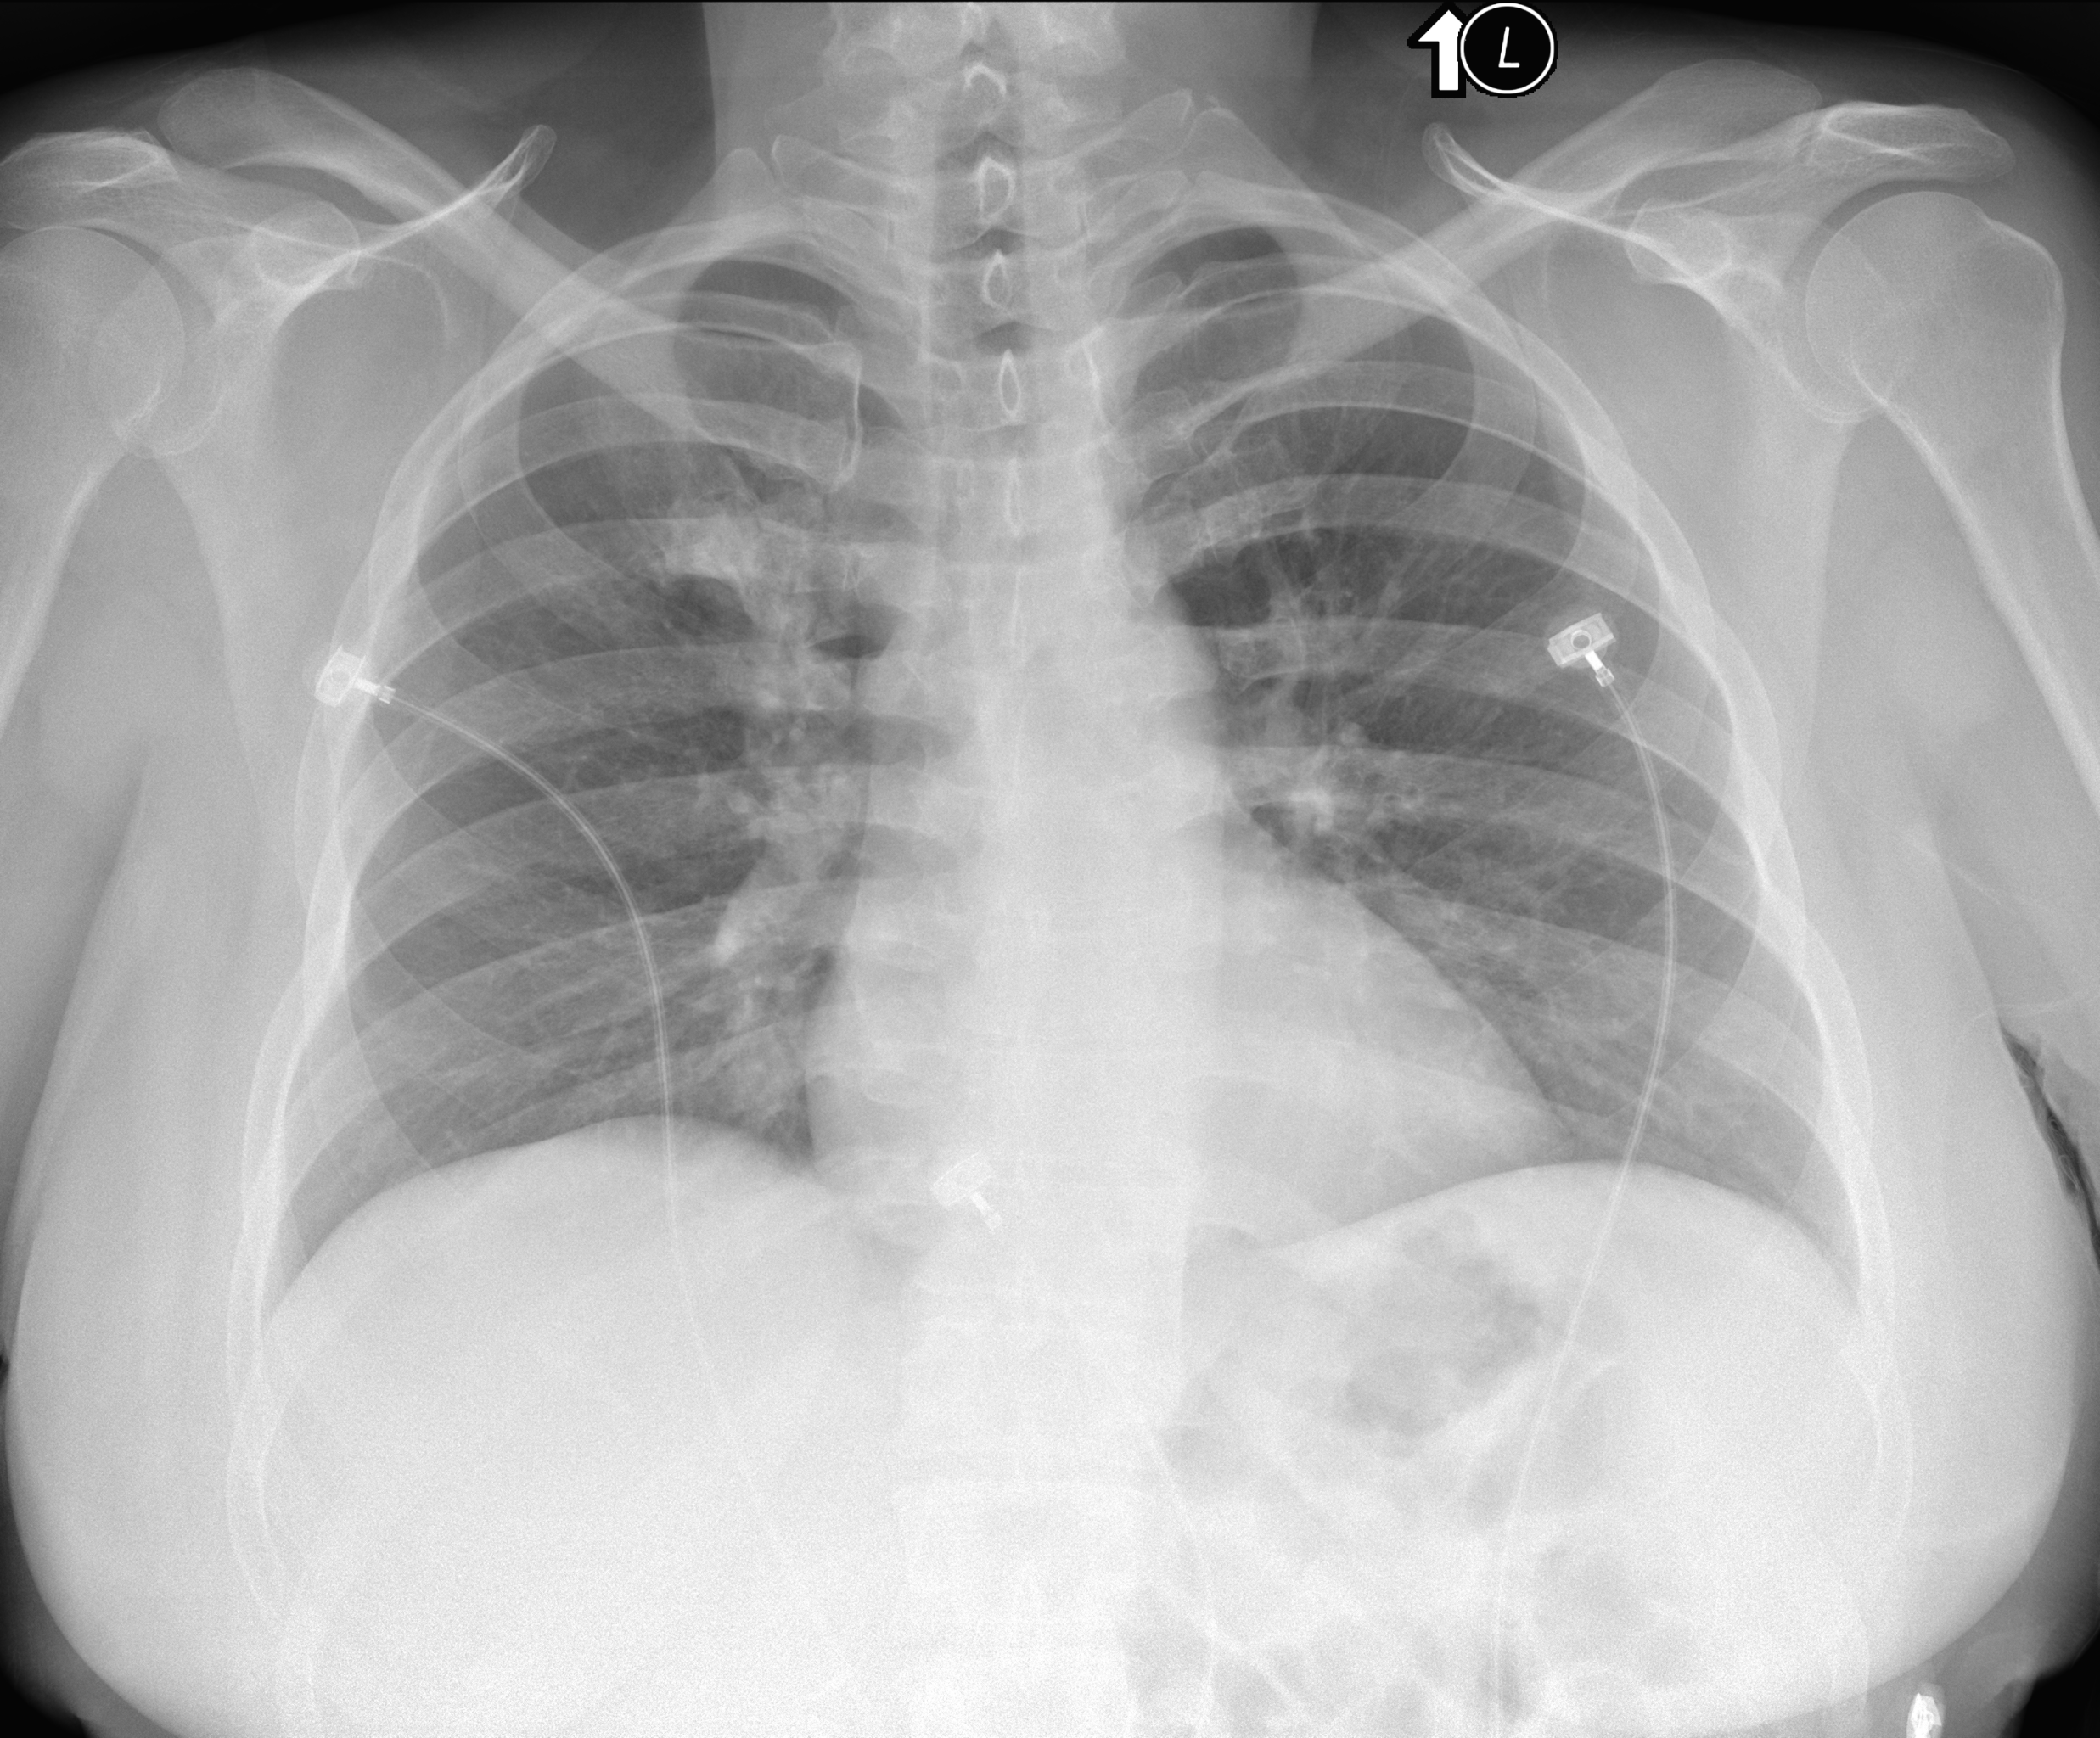

In [ ]:
# load the model
photo = list(test_features.values())[0]
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

from PIL import Image
import matplotlib.pyplot as plt

#frontal_train = pd.read_pickle("../data/train/frontal_train.pickle").reset_index(drop=True)

root_dir = "/datasets/gdrive/XRay-AKAKI/images_normalized/"

img = test_imgs[0]

img_path = root_dir + img
image = Image.open(img_path)
image

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d67d5ca8-f99a-4baf-8748-4aa99efbd09b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>